In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from astropy.io import fits
from os import listdir as ls
from matplotlib.colors import LogNorm
from scipy.optimize import leastsq as lmfitter
from scipy.stats import chi2

sns.set_context('talk')
sns.set_style('darkgrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Return list of filenames
# associated with a given string
def read_filetype(file_str):
    return np.sort([fname for fname in ls('.')
                    if (('fixed_header.fits' in fname)
                        & (file_str in fname))])

# Creates list of filenames for
# each image type
bias_fnames = read_filetype('BIAS')
dark_fnames = read_filetype('DARK')
flat_fnames = read_filetype('FLAT')
image_fnames = read_filetype('7')

# Given a single fits filename
# returns data of the fits file
# prints filter, exposure time
def read_fits(fits_fname, verbose=True):
    hdu = fits.open(fits_fname, uint=False)
    if verbose:
        print('File: ', fits_fname)
        print('Exposure Time: ', hdu[0].header['EXPOSURE'])
        print('Filter: ', hdu[0].header['FILTER'])
        print('\n')
    return hdu[0].data

# Given a list of N fits filenames
# with identical dimensions X, Y
# returns a numpy array with shape
# (N, X, Y) containing the data
# of the fits files
def make_fits_list_array(fits_list):
    test_data = read_fits(fits_list[0], verbose=False)
    (x_dim, y_dim) = np.shape(test_data)
    n_files = len(fits_list)
    all_array = np.empty((n_files, x_dim, y_dim))
    for i in range(0, n_files):
        all_array[i, :, :] = read_fits(fits_list[i])
    return all_array

def mode_numpy(array):
    uniques, counts = np.unique(array, return_counts=True)
    return uniques[np.argmax(counts)]

# Creates arrays for each image type
bias_all = make_fits_list_array(bias_fnames)
dark_all = make_fits_list_array(dark_fnames)
flat_all = make_fits_list_array(flat_fnames)
image_all = make_fits_list_array(image_fnames)

File:  00000010.BIAS.fixed_header.fits
Exposure Time:  0.0
Filter:  Halpha


File:  00000011.BIAS.fixed_header.fits
Exposure Time:  0.0
Filter:  Halpha


File:  00000012.BIAS.fixed_header.fits
Exposure Time:  0.0
Filter:  Halpha


File:  00000064.DARK.fixed_header.fits
Exposure Time:  300.0
Filter:  Clear


File:  00000065.DARK.fixed_header.fits
Exposure Time:  300.0
Filter:  Clear


File:  00000066.DARK.fixed_header.fits
Exposure Time:  300.0
Filter:  Clear


File:  00000043.FLAT.fixed_header.fits
Exposure Time:  4.0
Filter:  Clear


File:  00000044.FLAT.fixed_header.fits
Exposure Time:  4.0
Filter:  Clear


File:  00000045.FLAT.fixed_header.fits
Exposure Time:  4.0
Filter:  Clear


File:  00000075.fixed_header.fits
Exposure Time:  300.0
Filter:  Clear


File:  00000077.fixed_header.fits
Exposure Time:  300.0
Filter:  Red


File:  00000078.fixed_header.fits
Exposure Time:  300.0
Filter:  Green


File:  00000079.fixed_header.fits
Exposure Time:  300.0
Filter:  Blue




In [3]:
# Create median dark+bias
dark_median = np.median(dark_all, axis=0)
bias_median = np.median(bias_all, axis=0)

# Create median flat
temp_flat = flat_all - bias_median
flat_median = np.empty_like(temp_flat)
for i in range(0, len(flat_fnames)):
    flat_median[i, :, :] = temp_flat[i]/mode_numpy(temp_flat[i].flatten())
flat_median = np.median(flat_median, axis=0)

# Create reduced science image
image_all = (image_all - dark_median)/flat_median
image_all[np.where(image_all <= 0.0)] = 0.0

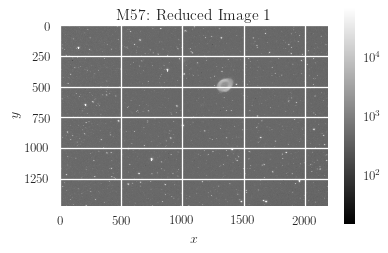

In [4]:
# Plot 1 reduced science image
ax = plt.imshow(image_all[0],
                norm=LogNorm(),
               cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('M57: Reduced Image 1')
plt.show()

In [5]:
bias_10_var = np.var(bias_all[0])
bias_10_mean = np.mean(bias_all[0])

print('Mean of First Bias = ', bias_10_mean)
print('Standard Deviation of First Bias = ', np.sqrt(bias_10_var))

Mean of First Bias =  103.26488033
Standard Deviation of First Bias =  6.88793392645


The mean is non-zero because of 2 things: the CCD bias is set to 100 counts and there is an unavoidable contribution from the electronics.

The standard deviation is non-zero because there is readout noise associated with the act of collecting electrons and counting them (presumably Poisson-distributed).

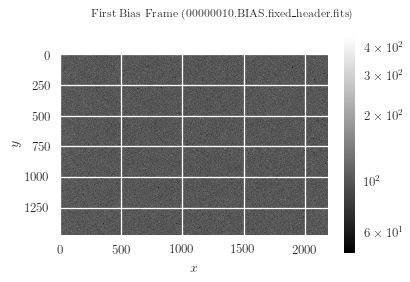

In [6]:
ax = plt.imshow(bias_all[0],
                norm=LogNorm(),
               cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.suptitle('First Bias Frame ($\mathrm{00000010.BIAS.fixed\_header.fits}$)')
plt.show()

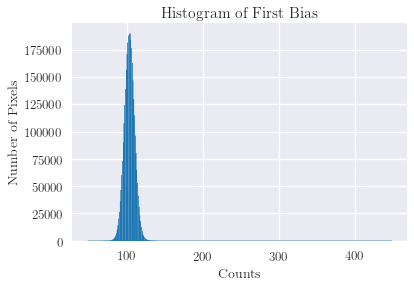

In [7]:
plt.hist(bias_all[0].flatten(), histtype='step', bins='auto')
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.title('Histogram of First Bias')
plt.show()

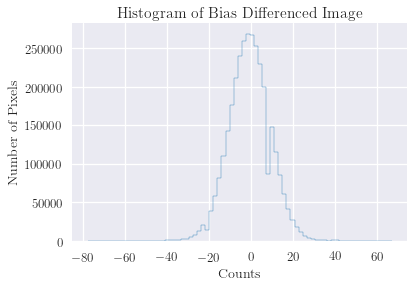

Standard Deviation of Bias Differenced Image:  9.68528899569
Inferred Standard Deviation of Single Frame:  6.8485335266
Inferred Readout Noise:  3.95400267514


In [8]:
bias_diff = bias_all[1] - bias_all[0]
bias_diff_var = np.var(bias_diff)
bias_single_var = bias_diff_var/2.0
ron_var_estimate = bias_single_var/3.0
plt.hist(bias_diff.flatten(), histtype='step', bins=75)
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.title('Histogram of Bias Differenced Image')
plt.show()
print('Standard Deviation of Bias Differenced Image: ',
     np.sqrt(bias_diff_var))
print('Inferred Standard Deviation of Single Frame: ',
     np.sqrt(bias_single_var))
print('Inferred Readout Noise: ',
     np.sqrt(ron_var_estimate))

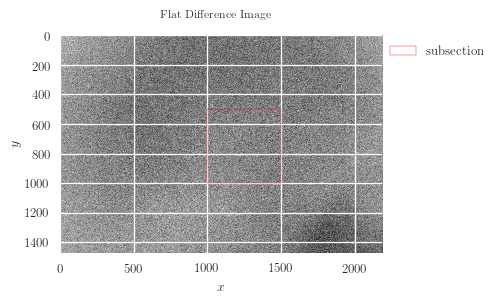

In [9]:
subsection_x = 1500
subsection_y = 1000
subsection_range = 500
x_coord = subsection_x - subsection_range
y_coord = subsection_y - subsection_range
flat_diff = flat_all[1] - flat_all[0]
fig, ax = plt.subplots(1)
ax.imshow(flat_diff, cmap='gray')
plt.gca().set_aspect('equal')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.suptitle('Flat Difference Image')
subsection_rect = patches.Rectangle((x_coord, y_coord),
                                    subsection_range,
                                    subsection_range,
                                    edgecolor='r',
                                    fill=False,
                                    label='subsection')
ax.add_patch(subsection_rect)
plt.legend(bbox_to_anchor=(1.35, 1.01))
plt.show()

In [10]:
subsection = flat_diff[x_coord:subsection_x,
                       y_coord:subsection_y].flatten()
subsection_var = np.var(subsection)
subsection_count = len(subsection)
total_count = len(flat_diff.flatten())
flat_var = subsection_var/2.0
print('Standard Deviation of Subsection Difference= ',
      np.sqrt(subsection_var))
print('Inferred Standard Deviation of Single Flat = ',
     np.sqrt(flat_var))

Standard Deviation of Subsection Difference=  169.549603289
Inferred Standard Deviation of Single Flat =  119.889674233


The $\sigma_{\mathrm{\tiny{DN}}}$ of the subsection is $\sim 100\sigma_{\mathrm{\tiny{RON}}}$ so we can safely neglect the readout noise for this gain estimate.

In [11]:
subsection_mean = np.mean(flat_all[0][x_coord:subsection_x,
                                      y_coord:subsection_y])
gain = subsection_mean/flat_var
print('Estimated Gain = ', gain)
print('FITS Header Gain = ',
      fits.open('00000010.BIAS.fixed_header.fits')[0].header['E-GAIN'])

Estimated Gain =  1.42635644163
FITS Header Gain =  1.43


This estimate is well within the uncertainty compared to the gain listed in the FITS header.

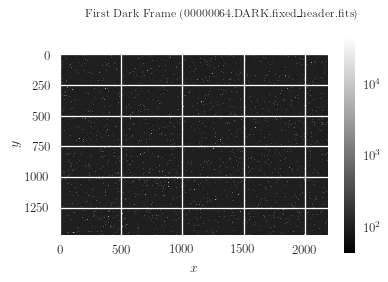

In [12]:
ax = plt.imshow(dark_all[0],
                norm=LogNorm(),
               cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.suptitle('First Dark Frame ($\mathrm{00000064.DARK.fixed\_header.fits}$)')
plt.show()

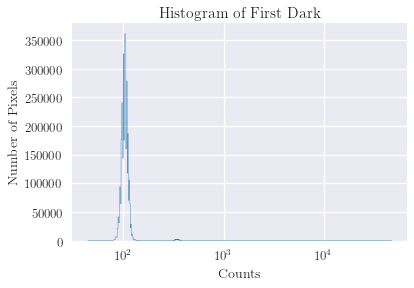

Number of Hot Pixels:  84710
Number of Normal Pixels:  3130138


In [13]:
dark_array = dark_all[0].flatten()
plt.hist(dark_array, histtype='step', bins=30000)
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.title('Histogram of First Dark')
plt.gca().set_xscale('log')
plt.show()
print('Number of Hot Pixels: ',
      len(dark_array[np.where(dark_array >= 250.0)]))
print('Number of Normal Pixels: ',
      len(dark_array[np.where(dark_array < 250.0)]))

The values of the dark are comparable to those of the bias within the Gaussian portion of the histogram. Outside this however, the darks go up to a factor of 100 times as much.

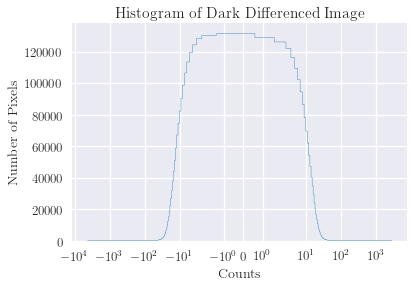

Standard Deviation of Dark Differenced Image:  12.3201871924
Mean of Dark Differenced Image:  -0.808963596413


In [14]:
dark_diff = dark_all[1] - dark_all[0]
dark_diff_var = np.var(dark_diff)
dark_diff_mean = np.mean(dark_diff)
dark_single_var = dark_diff_var/2.0
plt.hist(dark_diff.flatten(), histtype='step', bins=7200)
plt.gca().set_xscale('symlog')
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.title('Histogram of Dark Differenced Image')
plt.show()
print('Standard Deviation of Dark Differenced Image: ',
     np.sqrt(dark_diff_var))
print('Mean of Dark Differenced Image: ',
     dark_diff_mean)

Since the systematic outliers in the dark are **mostly** hot pixels that are consistently "hot" in the same way for both darks, they cancel each other out (with some scatter that is probably Poisson-distributed). A very small fraction of the outliers in any given dark are cosmic rays, but these should not add too much the variance of the differenced image. The mean being nearly zero is a good sign that the differences of the outliers have cancelled out.

$$\sigma^2_{\mathrm{\tiny{Dark \ Difference}}} = 2\times\left(\sigma^2_{\mathrm{\tiny{RON}}} + \sigma^2_{\mathrm{\tiny{Dark \ Current}}}\right)$$

$$\sigma^2_{\mathrm{\tiny{Dark \ Current \ Science \ Image}}} = \overbrace{\frac{\sigma^2_{\mathrm{\tiny{Dark \ Current}}}}{3}}^{\mathrm{Average}} + \underbrace{\sigma^2_{\mathrm{\tiny{Dark \ Current}}}}_{\mathrm{Science \ Image}}$$

In [15]:
dark_current_diff_var = (dark_diff_var - 2.0*bias_single_var)
dark_current_single_var = dark_current_diff_var/2.0
dark_science_var = dark_current_single_var*(1.0 + (1.0/3.0))
print('Readout Noise Contribution to Single Dark = ',
     np.sqrt(bias_single_var))
print('Dark Current Noise Contribution to Difference Dark = ',
     np.sqrt(dark_current_diff_var))
print('Dark Current Noise Contribution to Single Dark = ',
     np.sqrt(dark_current_single_var))
print('Dark Current Noise Contribution to Calibrated Science Image = ',
     np.sqrt(dark_science_var))


Readout Noise Contribution to Single Dark =  6.8485335266
Dark Current Noise Contribution to Difference Dark =  7.61460370117
Dark Current Noise Contribution to Single Dark =  5.38433791314
Dark Current Noise Contribution to Calibrated Science Image =  6.21729788712


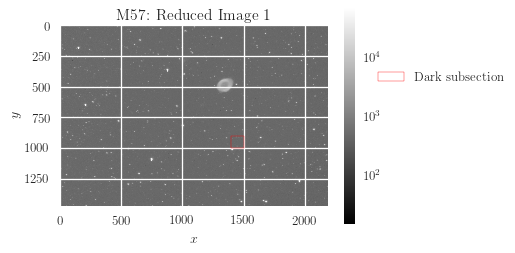

In [16]:
sub_x = 1500
sub_y = 1000
sub_range = 100
x_pos = sub_x - sub_range
y_pos = sub_y - sub_range
fig, ax = plt.subplots(1)
plt.imshow(image_all[0],
           norm=LogNorm(),
           cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()
sub_rect = patches.Rectangle((x_pos, y_pos),
                             sub_range,
                             sub_range,
                             edgecolor='r',
                             fill=False,
                             label='Dark subsection')
ax.add_patch(sub_rect)
plt.legend(bbox_to_anchor=(1.7, 0.81))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('M57: Reduced Image 1')
plt.show()

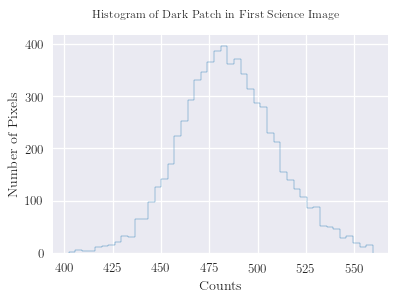

Mean of Dark Subsection =  485.254364736
Standard Deviation of Dark Subsection =  24.8182755454
Sky Noise Estimate =  23.6993221606
Poisson Prediction Sky Noise =  18.4446615826


In [17]:
subsection_2 = image_all[0, x_pos:sub_x, y_pos:sub_y].flatten()
subsection_2 = subsection_2[np.where((subsection_2 <= 560)
                                    & (subsection_2 >= 400))]
plt.hist(subsection_2, histtype='step', bins='auto')
plt.xlabel('Counts')
plt.ylabel('Number of Pixels')
plt.suptitle('Histogram of Dark Patch in First Science Image')
plt.show()
subsection_2_mean = np.mean(subsection_2)
subsection_2_var = np.var(subsection_2)
print('Mean of Dark Subsection = ',
      subsection_2_mean)
print('Standard Deviation of Dark Subsection = ',
     np.sqrt(subsection_2_var))
extra_var = ron_var_estimate + dark_science_var
sky_var = (subsection_2_var - extra_var)
print('Sky Noise Estimate = ',
     np.sqrt(sky_var))
print('Poisson Prediction Sky Noise = ',
     np.sqrt(subsection_2_mean/gain))

The Poisson prediction is slightly lower than our sky noise estimate derived by removing the readout noise and dark current and dominates over both the readout noise and dark current components. The discrepancy may be due to a poor choice of dark subsection, an additional source of noise that hasn't been considered, or that airglow does not follow a Poissonian distribution.

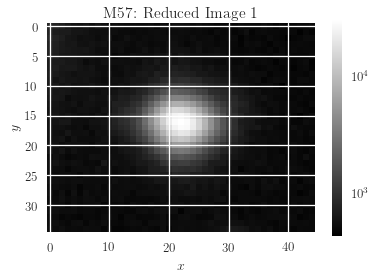

In [18]:
fig, ax = plt.subplots(1)
plt.imshow(image_all[0][465:500, 1415:1460],
           norm=LogNorm(),
           cmap='gray')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('M57: Reduced Image 1')
plt.show()

In [19]:
def get_noise(data, term_1=subsection_2_var, gain=gain):
    term_2 = data/gain
    return np.sqrt(term_1 + term_2)

def get_chi(theta, data, noise):
    xx, yy = np.meshgrid(np.arange(len(data[0, :])), np.arange(len(data[:, 0])))
    model = theta[1] + theta[0]*np.exp(-((xx - theta[2])**2.0
                                         + (yy - theta[3])**2.0)/(2.0*(theta[4]**2.0)))
    return np.array((model - data)/noise).flatten()

In [20]:
# Fitting the circular Gaussian
# to the star.

data = image_all[0][465:500, 1415:1460]
noise = get_noise(data)
init_guess = np.array([3000.0, 560, 22.0, 16.0, 2.5])
result = lmfitter(get_chi, init_guess, args=(data, noise), full_output=1)
xx, yy = np.meshgrid(np.arange(len(data[0, :])), np.arange(len(data[:, 0])))
final_theta = result[0]
final_model = final_theta[1]
final_model += final_theta[0]*np.exp(-((xx
                                        - final_theta[2])**2.0
                                       + (yy
                                          - final_theta[3])**2.0)/
                                     (2.0*(final_theta[4]**2.0)))
min_chi2 =  np.sum(result[2]['fvec']**2.0)
total_dof = len(data.flatten()) - len(final_theta)
scale_factor = min_chi2/total_dof
cov_matrix = result[1]* scale_factor
print('A: ', final_theta[0])
print('B: ', final_theta[1])
print('x_0 : ', final_theta[2])
print('y_0: ', final_theta[3])
print('sigma: ', final_theta[4])
print('Minimum Chi^2: ', min_chi2)
print('PTE: ', chi2.sf(min_chi2, total_dof))
print('Amplitude Uncertainty: ', np.sqrt(cov_matrix[0, 0]))
print('Data Uncertainty at Peak: ',
      np.max(noise))

A:  27666.5261392
B:  574.357330566
x_0 :  22.0517478278
y_0:  16.2579474171
sigma:  2.31038462825
Minimum Chi^2:  51263.9927659
PTE:  0.0
Amplitude Uncertainty:  227.034303775
Data Uncertainty at Peak:  148.978662419


The amplitude uncertainty is comparable to the data uncertainty, but this should not be the case. I am unsure of what is happening here.